In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import scipy.stats as stats
import pylab 
from matplotlib import cm
import scipy.integrate as integrate
from contextlib import suppress

## 1.1 read real time soil moisture data (recorded every 15min )

In [2]:
url="https://datagarrison.com/users/1105898/351579054849888/temp/351579054849888_live.txt"
#read soil moisture data from url (bioswale 9A)
soilfile=pd.read_csv(url,sep="\t",skiprows=[0,1], parse_dates=[0], index_col=[0])
soilfile.head()

,Temperature_10417147_deg_F,Water Content_10722585_m^3/m,Water Content_10722578_m^3/m,Water Content_10722572_m^3/m,Unnamed: 5
Date_Time,,,,,
2016-08-24 11:15:00,84.093,0.211,0.227,0.191,NaN
2016-08-24 11:30:00,83.645,0.211,0.228,0.190,NaN
2016-08-24 11:45:00,83.377,0.211,0.229,0.190,NaN
2016-08-24 12:00:00,83.243,0.210,0.229,0.188,NaN
2016-08-24 12:15:00,83.109,0.210,0.229,0.188,NaN


**In this bioswale (also named rain garden) three soil moisture sensors was installed by researchers in our group.
These sensors located at 10, 30, 50 centimeters below the ground level respectively.
However, the raw data was without explicitly annotation, therefore, annotation should be added manually.**

In [3]:
soilfile.columns = ['temperature','thirty_cm','fifty_cm','ten_cm','NaN']
soilfile = soilfile.drop('NaN', axis=1)
soilfile.head()

,temperature,thirty_cm,fifty_cm,ten_cm
Date_Time,,,,
2016-08-24 11:15:00,84.093,0.211,0.227,0.191
2016-08-24 11:30:00,83.645,0.211,0.228,0.190
2016-08-24 11:45:00,83.377,0.211,0.229,0.190
2016-08-24 12:00:00,83.243,0.210,0.229,0.188
2016-08-24 12:15:00,83.109,0.210,0.229,0.188


**change the order of columns that stores soil moisture data from the shallowest position to the deepest position**

In [4]:
cols = soilfile.columns.tolist()
print("the origin order:",cols)
cols = cols[:1] + cols[-1:] + cols[1:-1]
print("organized:",cols)
soilfile = soilfile[cols]
soilfile.head()

the origin order: ['temperature', 'thirty_cm', 'fifty_cm', 'ten_cm']
organized: ['temperature', 'ten_cm', 'thirty_cm', 'fifty_cm']


,temperature,ten_cm,thirty_cm,fifty_cm
Date_Time,,,,
2016-08-24 11:15:00,84.093,0.191,0.211,0.227
2016-08-24 11:30:00,83.645,0.190,0.211,0.228
2016-08-24 11:45:00,83.377,0.190,0.211,0.229
2016-08-24 12:00:00,83.243,0.188,0.210,0.229
2016-08-24 12:15:00,83.109,0.188,0.210,0.229


## 1.2 read real time rainfail datafile (recorded every 15min )

In [5]:
url="https://datagarrison.com/users/1105898/351579054849540/temp/351579054849540_live.txt"
#read rainfall data from url (abc carpet)
rainfile=pd.read_csv(url,sep="\t",skiprows=[0,1], parse_dates=[0], index_col=[0],usecols=[0, 3])
rainfile.columns = ['rain_inch']
rainfile.head()

,rain_inch
Date_Time,
2015-08-09 06:00:00,0.0
2015-08-09 06:15:00,0.0
2015-08-09 06:30:00,0.0
2015-08-09 06:45:00,0.0
2015-08-09 07:00:00,0.0


### 1.2.1 Precipitation data is measured locally by our own rain gage since 2015 as shown above. The timestamp of the data is found maybe ahead of the actual precipitation for about an hour, therefore, reindexing might be needed but further measurement need to be done (ongoing) before reaching to the final conclusion.

In [6]:
#code for reindexing if needed

# rainfile.index + pd.DateOffset(hours=1)
# rainfile.index=rainfile.index + pd.DateOffset(hours=1)
# rainfile.head()

 ### 1.2.2 combining rainfall data with the soil moisture data (matching time) and convert the rain depth unit

In [7]:
#convert rain data unit (rain depth) from inch to cm
soilfile['rain_cm']=rainfile*2.54

In [8]:
soilfile.head()

,temperature,ten_cm,thirty_cm,fifty_cm,rain_cm
Date_Time,,,,,
2016-08-24 11:15:00,84.093,0.191,0.211,0.227,0.0
2016-08-24 11:30:00,83.645,0.190,0.211,0.228,0.0
2016-08-24 11:45:00,83.377,0.190,0.211,0.229,0.0
2016-08-24 12:00:00,83.243,0.188,0.210,0.229,0.0
2016-08-24 12:15:00,83.109,0.188,0.210,0.229,0.0


### 1.2.3 visualize soil moisture data with temperature data

**As shown below, there are three abnormal peak in the soil moisture data, the anormalies was suspect to be caused by low temperature, the figure below verified the conjecture. So the anormalies should be excluded in the data analysis**

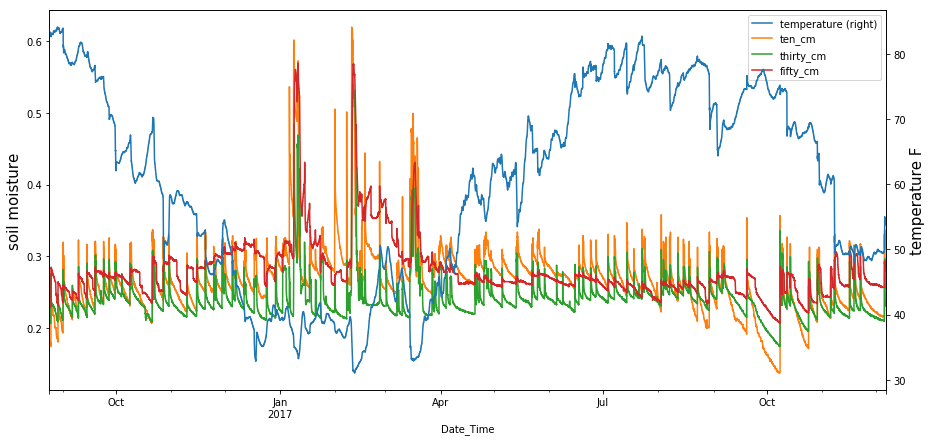

In [9]:
fig, ax = plt.subplots(1,1,figsize=(15,7))
soilfile[['temperature','ten_cm','thirty_cm','fifty_cm']].plot(ax=ax,secondary_y=['temperature'])
ax.set_ylabel('soil moisture',size=15)
ax.right_ax.set_ylabel('temperature F',size=15)
fig.savefig('soil_moisture_temperature.pdf')

### 1.2.4 visualize soil moisture data with rainfall data

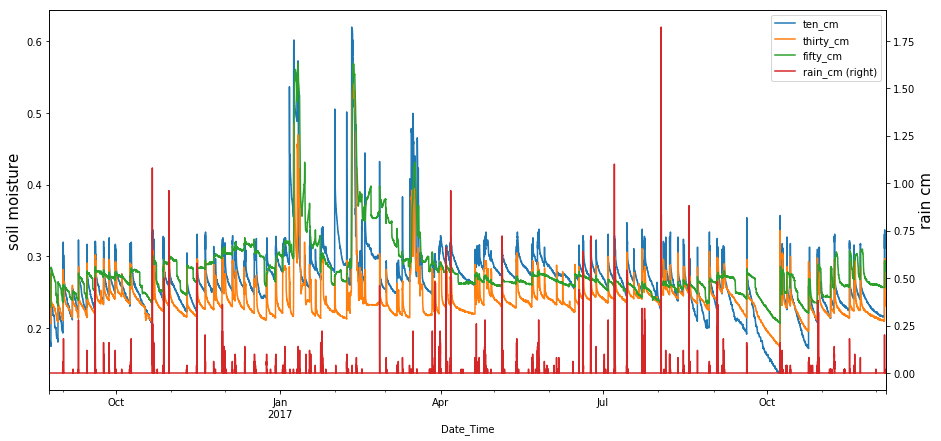

In [10]:
fig, ax = plt.subplots(1,1,figsize=(15,7))
soilfile[['ten_cm','thirty_cm','fifty_cm','rain_cm']].plot(ax=ax,secondary_y=['rain_cm'])
ax.set_ylabel('soil moisture',size=15)
ax.right_ax.set_ylabel('rain cm',size=15)
fig.savefig('soil_moisture_rainfall.pdf')

# 2. Plot rainfall parameter versus peak value of soil moisture probes that are 10cm, 30cm, 50cm below the ground

**Except the anormalies from about Jan.2017 to April.2017, each peak of soil moisture data (including values at different depths) is believed to be caused by a rain event. To quntify the relationship between rainfall and soil moisture, some exploratory analysis was performed.**

**The following analysis are:**

**
Firstly, exclude data from Jan.2017 to April.2017**

**Secondly, separate each rain event by sperator=6, 12, 24, 48 hours respectively**

**Thirdly, plot out the scatter plot of rain depth, average rainfall intensity and maximum rainfall intensity of each rainfall event vesus soil moisture peak at different depth**

**2.1 Drop the anormaly**

In [11]:
soilfile_mask=soilfile.drop(soilfile.index[12000:21200])

In [12]:
def separate_rain(interval,soilfile_mask):
    """function that producees the row indexes for the beginning and the end time point of each rainfall event
    
    *Input*: 
    Interval: (int) Rain sperator; the time interval to separate each rainfall event    
              (the number should be desired_hours*4, 4 rows represents 1 hour)
    Soilfile_mask: pd.DataFrame The rain data dataframe/ dataframe contains rain data of desired
    
    
    *Output*:
    rainfall_index: numpy.array, with first column as the row number corresponding to the start point of a rain
                                with second column as the row number corresponding to the end point of a rain
    """
    
    lag_nonzero_mask=soilfile_mask.rain_cm.nonzero()[0][1:] # find the nonzero row_number that from the second to the last one
    origin_nonzero_mask=soilfile_mask.rain_cm.nonzero()[0][:-1]  #find the nonzero row_number that from the first one to the last second
    diff_mask=lag_nonzero_mask-origin_nonzero_mask
    
    index_indp_mask=np.where(diff_mask >= interval)   #searching for the event that has interval larger than 6 hours
    index_indp_mask=np.asarray(index_indp_mask) #make the turple to be an array
    iidp_mask=index_indp_mask[0] #convert it to 1-d array
    
    #initiate
    start_index_mask=np.zeros(iidp_mask.shape[0])
    end_index_mask=np.zeros(iidp_mask.shape[0])
    rainfall_index=np.zeros((iidp_mask.shape[0],2))
    
    for n,v in enumerate(iidp_mask):
        end_index_mask[n]=origin_nonzero_mask[v]  #the row number of end of each rain 

        if iidp_mask[n]==0: #the starting point and end point to be the same
            start_index_mask[n]=end_index_mask[n]  #the row number of start of each rain 
        
        elif n==0:
            start_index_mask[n]=origin_nonzero_mask[0]
        
        else:
            st_i=iidp_mask[n-1]
            start_index_mask[n]=lag_nonzero_mask[st_i]
            
    start_index_mask=start_index_mask.astype(int)
    end_index_mask=end_index_mask.astype(int)
    rainfall_index[:,0]=start_index_mask.astype(int)
    rainfall_index[:,1]=end_index_mask.astype(int)
    
    return rainfall_index

In [13]:
def rain_inf(rain_index,soilfile_mask):
    """function that calculate the rainfall parameters (total rain depth, average rainfall intensity, 
    max rainfall intensity)  and the corresponding peak value of soil mousture at 
    different depths for each event"
    
    *Input*:
    rainfall_index: numpy.array from output of the function "separate_rain" (last function)
    soilfile_mask: pd.DataFrame dataframe contains rain data and soil moisture at different depth of desired
    
    *Output*:
    A dict including all the information needed for each rainfall data analysis:
    (1)total rain depth (cm) for each rainfall event
    (2)average intensity (cm/hr) for each event
    (3)max intensity (cm/hr) within 15 min for each event
    (4)peak value of soil moisture data at 10,30,50 cm below the ground for each event
    """
    rain_depth_mask=[]
    rain_ave_inst_mask=[]
    rain_max_inst_mask=[]
    sm_10cm_peak_mask=[]
    sm_30cm_peak_mask=[]
    sm_50cm_peak_mask=[]
    
    start_index_mask=rain_index[:,0]
    end_index_mask=rain_index[:,1]

    for i1,i2 in zip(start_index_mask,end_index_mask):
        if i1==i2:  #start point and end point is the same
            rain_depth_mask.append(soilfile_mask.rain_cm.iloc[i1])
            rain_ave_inst_mask.append(soilfile_mask.rain_cm.iloc[i1]*60/15)  # cm/hr
            rain_max_inst_mask.append(soilfile_mask.rain_cm.iloc[i1]*60/15)
            sm_10cm_peak_mask.append(soilfile_mask.ten_cm.iloc[i1])
            sm_30cm_peak_mask.append(soilfile_mask.thirty_cm.iloc[i1])
            sm_50cm_peak_mask.append(soilfile_mask.fifty_cm.iloc[i1])
        else:
            rain_depth_mask.append(soilfile_mask.rain_cm.iloc[i1:i2+1].sum())
            rain_ave_inst_mask.append(soilfile_mask.rain_cm.iloc[i1:i2+1].sum()*60/(15*(i2-i1+2)))
            rain_max_inst_mask.append(soilfile_mask.rain_cm.iloc[i1:i2+1].max()*60/15)  #cm/hr
            sm_10cm_peak_mask.append(soilfile_mask.ten_cm.iloc[i1:i2+1].max())
            sm_30cm_peak_mask.append(soilfile_mask.thirty_cm.iloc[i1:i2+1].max())
            sm_50cm_peak_mask.append(soilfile_mask.fifty_cm.iloc[i1:i2+1].max())

    rain_depth_mask=np.array(rain_depth_mask)
    rain_ave_inst_mask=np.array(rain_ave_inst_mask)
    rain_max_inst_mask=np.array(rain_max_inst_mask)
    sm_10cm_peak_mask=np.array(sm_10cm_peak_mask)
    sm_30cm_peak_mask=np.array(sm_30cm_peak_mask)
    sm_50cm_peak_mask=np.array(sm_50cm_peak_mask)
    
    
    raininf = {'rain_depth': rain_depth_mask,
            'rain_ave_inst': rain_ave_inst_mask,
            'rain_max_inst': rain_max_inst_mask,
            'sm_10cm_peak':sm_10cm_peak_mask,
              'sm_30cm_peak':sm_30cm_peak_mask,
              'sm_50cm_peak':sm_50cm_peak_mask}
    
    return raininf

** 2.2 The following code run the two functions above to separate rainfall event from the whole dataset ( function:separate_rain() )and calculate the corresponding peak soil moisture data at diffeerent depths and rain depth, average rain intensity and maximum rain intensity for each event (function: rain_inf() ).**

In [14]:
interval=[6,12,24,48] #the separators for rain separation

# Data is recorded every 15 minitues, the desired separators*4 would be corresponding row number
interval_row=[i * 4 for i in interval] 

for i1,i2 in zip(interval_row,interval):
    locals()['rainindex_{0}hr'.format(i2)]=separate_rain(i1,soilfile_mask) #get rain index for each separator
    trans=separate_rain(i1,soilfile_mask).astype(int)
    trans1=pd.DataFrame(rain_inf(trans,soilfile_mask)) #get rain information and soil moisture information for each separator
    locals()['raindata_{0}hr'.format(i2)]=trans1[['rain_depth','rain_ave_inst','rain_max_inst']]
    locals()['soildata_{0}hr'.format(i2)]=trans1[['sm_10cm_peak','sm_30cm_peak','sm_50cm_peak']]

** 2.3 The following code plot the relationship between each rain parameters (as stated several times above: rain depth, average rain intensity and maximum rain intensity for each rainfall event) versus the peak value of soil moisture at different depth for each rain event by different rain separators. **

**There are two reasons to do this analysis:**

**(1) Rain data and soil moisture data are recorded separately by two systems, the timestamp of these two systems may not align with each other, focusing on the peak of soil moisture data in each event could help avoiding the timing problem.**

**(2) If there is a relationship between peak of the soil moisture and rain depth, this relationship can be used explicitly in the future to predict the peak of soil moisture, which can be convert to the maximum infiltration quantity.**

**From the plots below, we could see that, separators = 24 hours provides the best linear result between rain depth and peak value of soil moisture at different depths.**

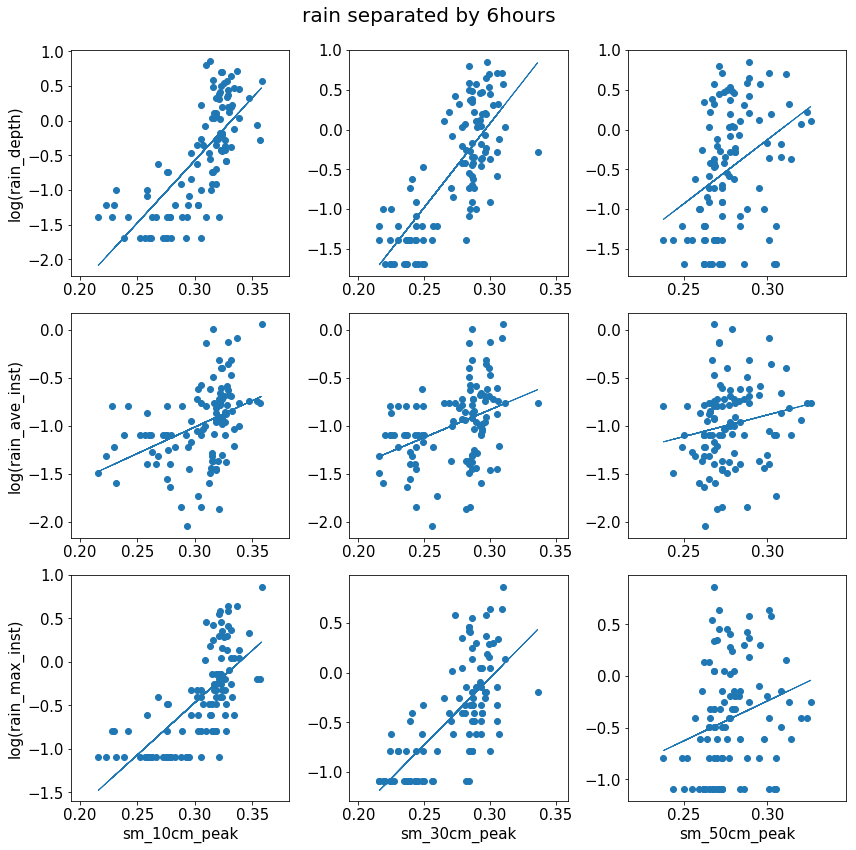

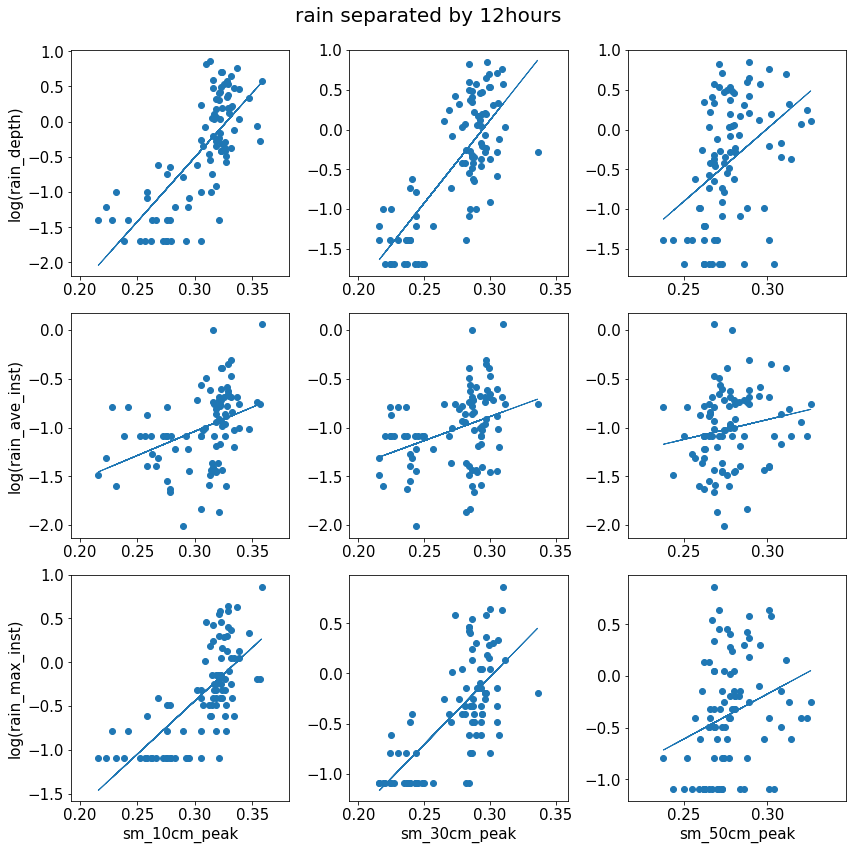

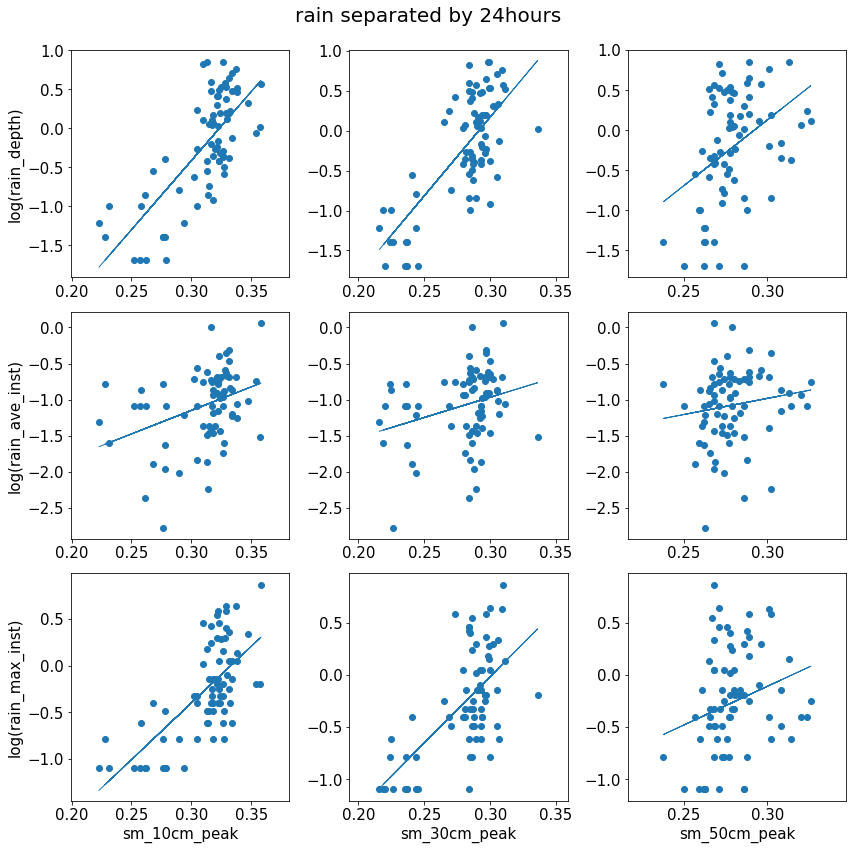

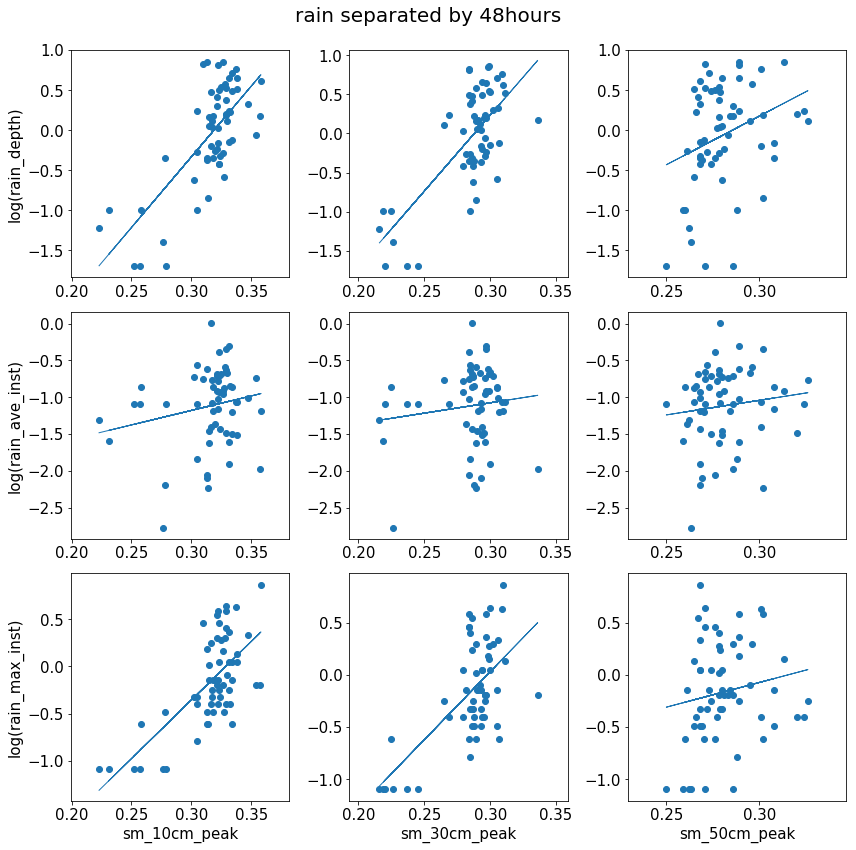

In [15]:
interval=[6,12,24,48]
for i in interval:
    fig,axes = plt.subplots(3,3,figsize=(12,12))
    axes=axes.flatten()
    a=0
    rain_str='raindata_{0}hr'.format(i)
    soil_str='soildata_{0}hr'.format(i)
    for r in globals()[rain_str]:
        for s in globals()[soil_str]:
            axes[a].scatter(globals()[soil_str][s],np.log10(globals()[rain_str][r]))
            axes[a].tick_params(axis='both', which='major', labelsize=15)
            m, b = np.polyfit(globals()[soil_str][s], np.log10(globals()[rain_str][r]), 1)
            axes[a].plot(globals()[soil_str][s], m*globals()[soil_str][s]+b, lw=1., label="y={:.2f}x+{:.2f}".format(m,b))
            if a>5:
                axes[a].set_xlabel(str(s),size=15)
            if (a==0)or(a==3)or(a==6):
                axes[a].set_ylabel("log("+str(r)+")",size=15)
            a+=1
    suptitle="rain separated by "+ str(i) + "hours"
    fig.suptitle(suptitle, fontsize=20)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()
    figname='rain_inf_vs_peak_soil_moisture_{0}hrs.pdf'.format(i)
    fig.savefig(figname)

## export data

In [16]:
# for i in interval:
#     rain_str='raindata_{0}hr'.format(i)
#     soil_str='soildata_{0}hr'.format(i)
#     store_rain="/Users/admin/Desktop/SM_analysis/output/"+rain_str+".csv"
#     store_soil="/Users/admin/Desktop/SM_analysis/output/"+soil_str+".csv"
#     globals()[rain_str].to_csv(store_rain, sep='\t',index=False)
#     globals()[soil_str].to_csv(store_soil, sep='\t',index=False)

# 3. Plot the soil moisture profile 

** The following plot shows the soil moisture at different depths changing with time (every two hours) in each rainfall event, the colormap was chose to be 'autumn', so red lines are the soil moisture profile at the beginning, yellow lines are nearly the end of each rainfall event, each plot represent one rainfall event. These plot can help to get insight of the changing of the soil moisture in each rainfall event every two hours.**

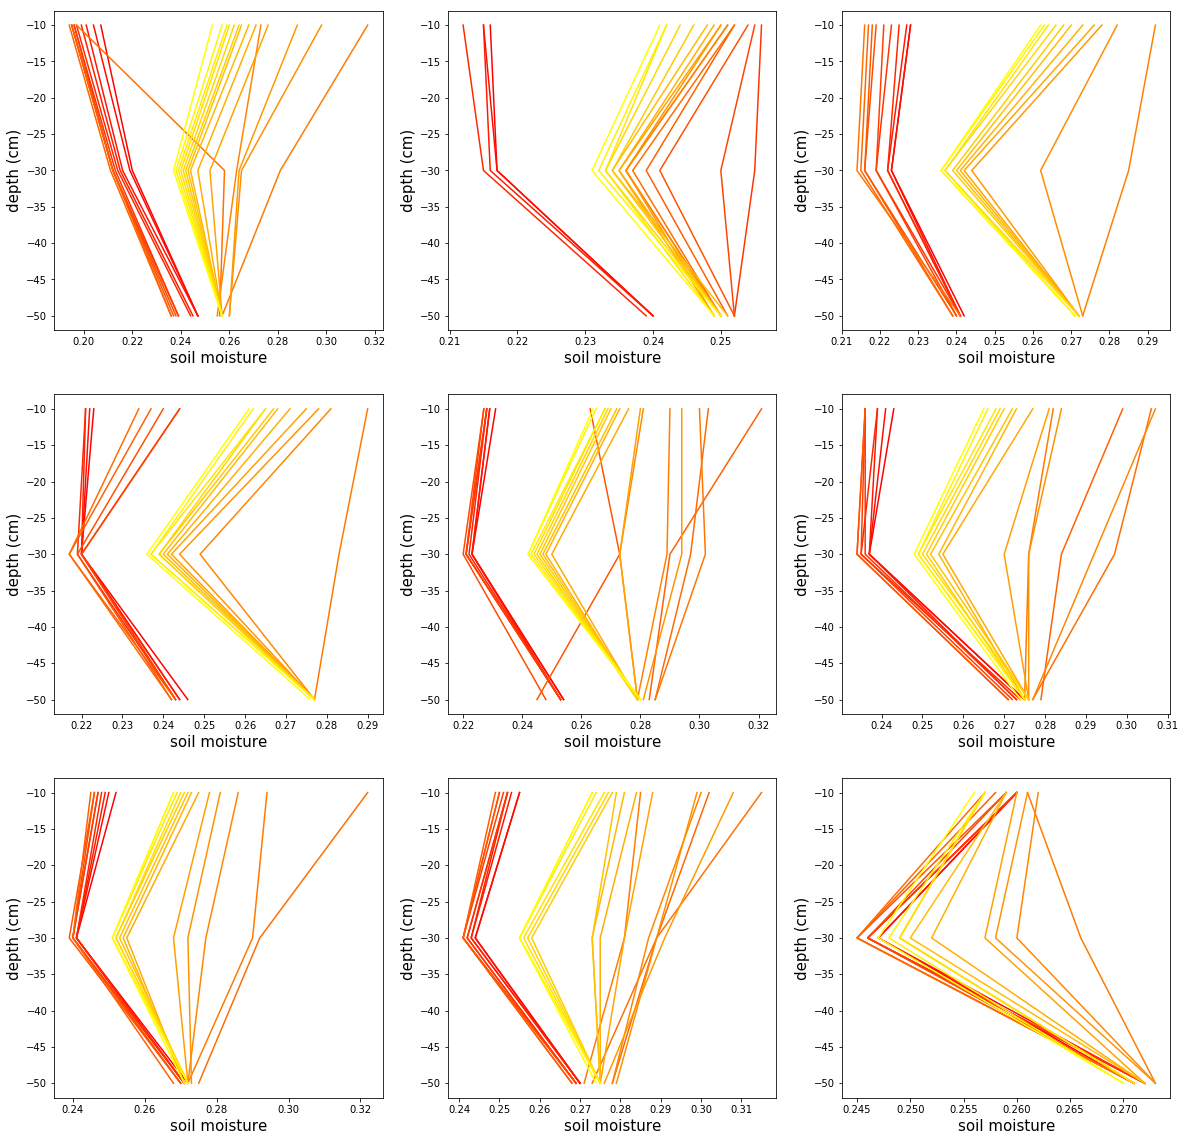

In [17]:
## raw data (soil moisture profile every two hours)
from matplotlib import cm
depth=[-10,-30,-50]
fig,axes = plt.subplots(3,3,figsize=(20,20))

#rain separator as 24 hours
start_index_mask=globals()['rainindex_{0}hr'.format(24)].astype(int)[:,0]
end_index_mask=globals()['rainindex_{0}hr'.format(24)].astype(int)[:,1]

colormap = plt.cm.autumn    

for i,ax in enumerate(axes.flatten()): 
    time_len=end_index_mask[i]-start_index_mask[i]
    len_2hr=int(np.floor(time_len/8.0))
    colors = [colormap(k) for k in np.linspace(0, 1,len_2hr+20)]
    for j in range(len_2hr+20):
        ax.plot(soilfile_mask[['ten_cm','thirty_cm','fifty_cm']].iloc[(start_index_mask[i]+(j-8)*8)],depth,color=colors[j])
        ax.set_xlabel("soil moisture",size=15)
        ax.set_ylabel("depth (cm)",size=15)

figname='raw_soil_moisture_profile_{0}hrs.pdf'.format(24)
fig.savefig(figname)

**In this research, infiltration is of interest, meaning that we concern more about how soil moisture changed by rainfall, therefore, if the initial soil moisture data at different depth being substracted, we can have a more straight-forward sense of the profile changed by rain. The following plots emphasis on the changing profile of soil moisture while the initial soil moisture was substracted.**

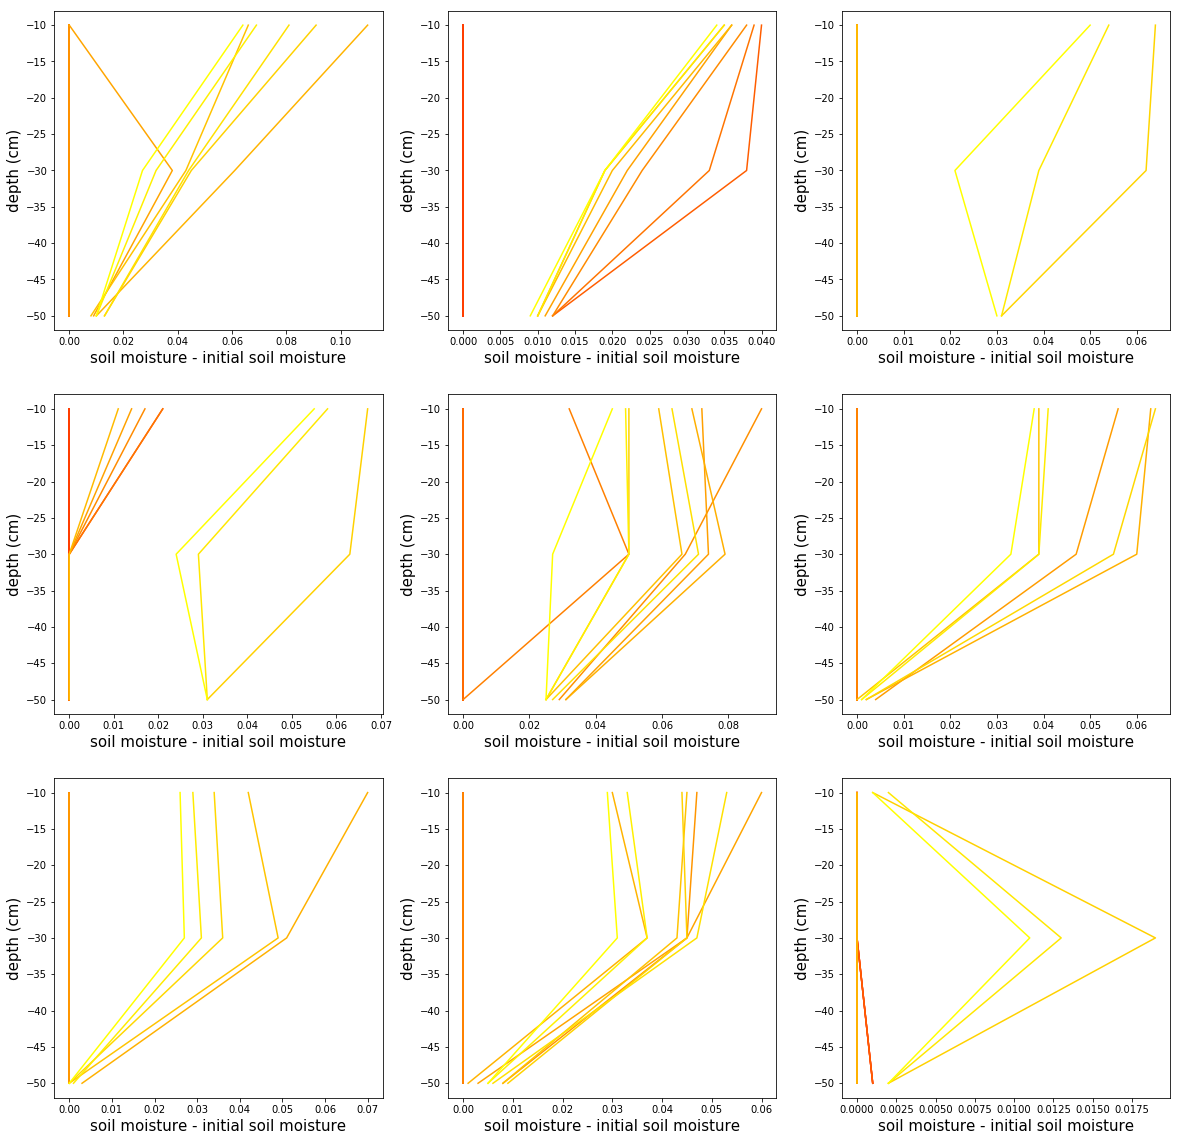

In [18]:
## delta soilmoisture data (soil moisture profile every two hours)
from matplotlib import cm
depth=[-10,-30,-50]
fig,axes = plt.subplots(3,3,figsize=(20,20))

#rain separator as 24 hours
start_index_mask=globals()['rainindex_{0}hr'.format(24)].astype(int)[:,0]
end_index_mask=globals()['rainindex_{0}hr'.format(24)].astype(int)[:,1]

colormap = plt.cm.autumn #nipy_spectral, Set1,Paired   

i=0
for ax in axes.flatten(): 
    time_len=end_index_mask[i]-start_index_mask[i]
    len_2hr=int(np.floor(time_len/8.0))
        
    colors = [colormap(k) for k in np.linspace(0, 1,len_2hr+12)]
    for j in range(len_2hr+12):
        delta_sm=(soilfile_mask[['ten_cm','thirty_cm','fifty_cm']].iloc[(start_index_mask[i]+(j-8)*8)]-\
                 soilfile_mask[['ten_cm','thirty_cm','fifty_cm']].iloc[(start_index_mask[i]-64)])
        dsm=delta_sm*(delta_sm >= 0)
        ax.plot(dsm,depth,color=colors[j])
        ax.set_xlabel("soil moisture - initial soil moisture",size=15)
        ax.set_ylabel("depth (cm)",size=15)
    i+=1

figname='soil_moisture_profile_without_initial{0}hrs.pdf'.format(24)
fig.savefig(figname)

# 4. Time matching/time difference calculation between soil moisture data and rainfall data

** To begin with, 9 rainfall events with the corresponding soil moisture data was plotted below.It will be normal to see the soil moisture change synchronize with the rain (in big rain event) or a little later than the beginning of the rain, but there are also some events without significant changes in soil moisture.**

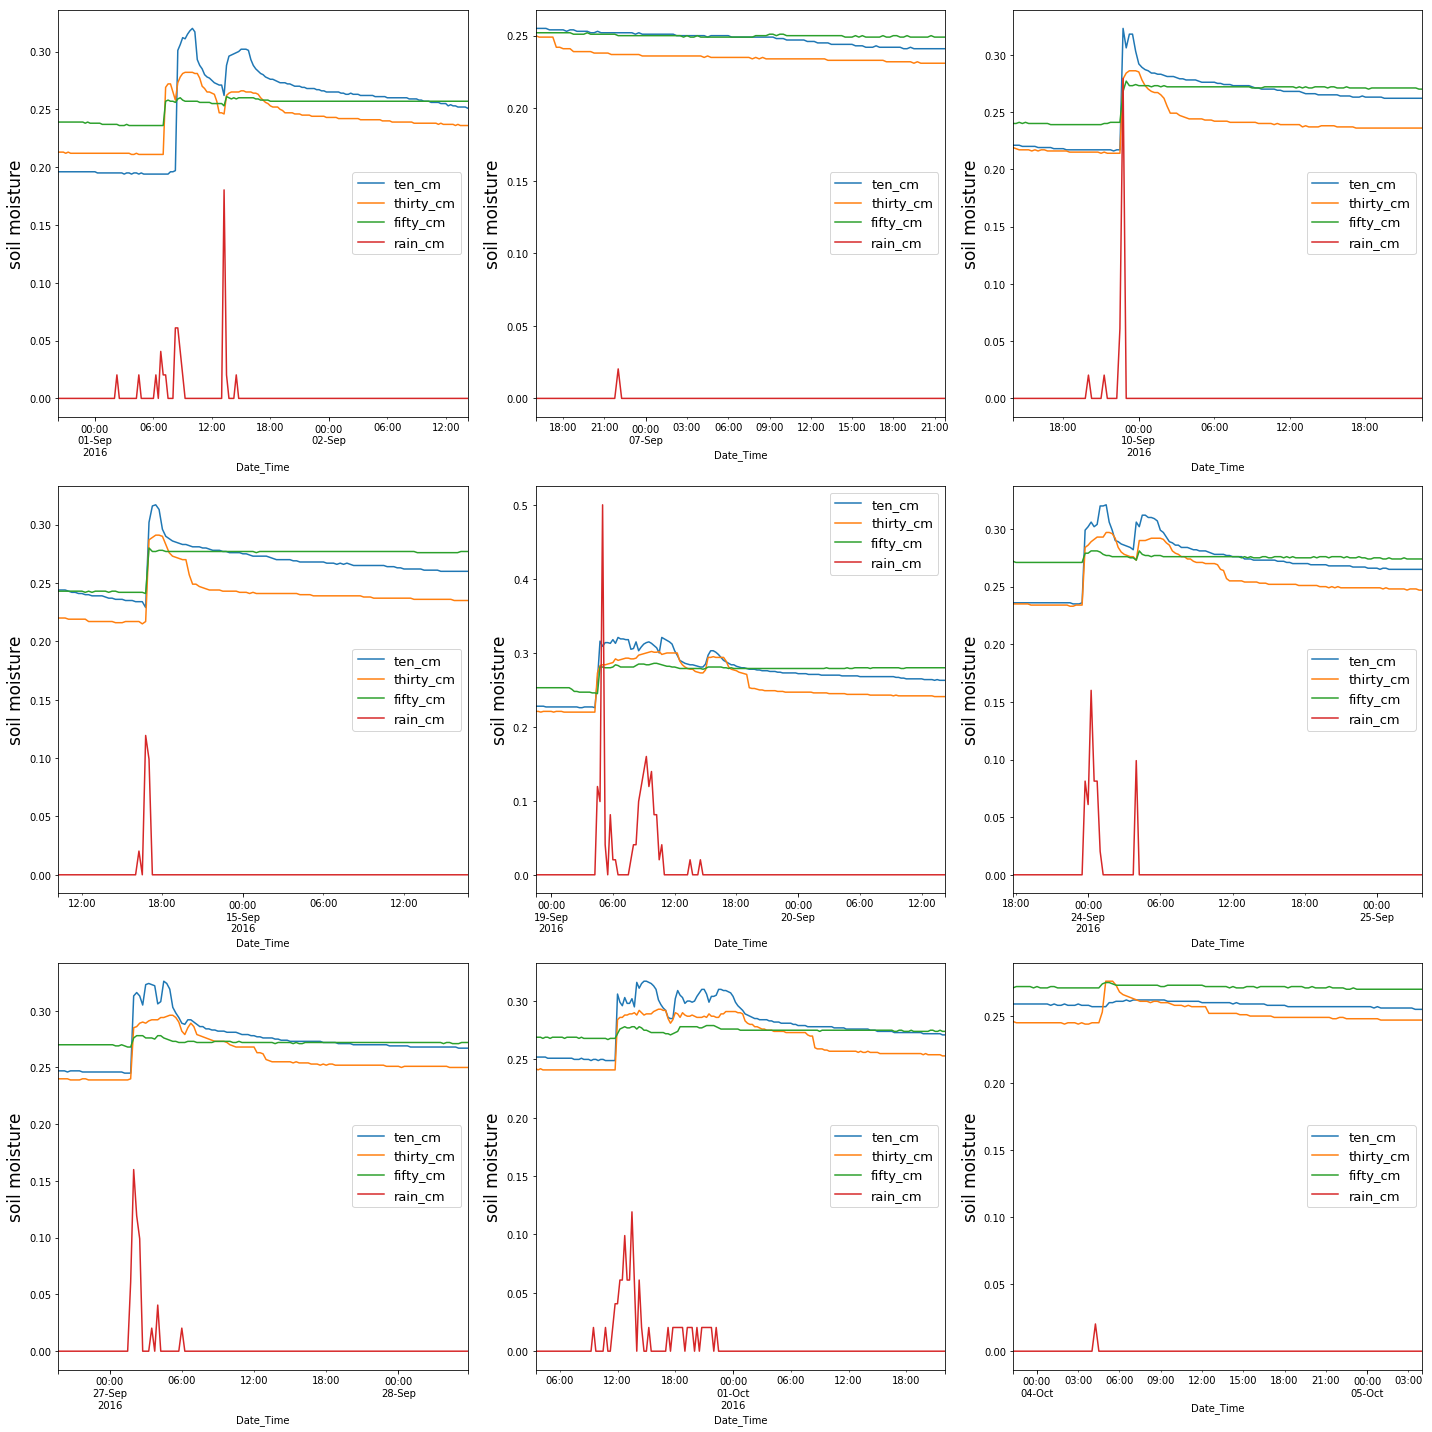

In [19]:
start_index_mask=globals()['rainindex_{0}hr'.format(48)].astype(int)[:,0]
end_index_mask=globals()['rainindex_{0}hr'.format(48)].astype(int)[:,1]

fig,axes = plt.subplots(3,3,figsize=(20,20))
for i,ax in enumerate(axes.flatten()):
    soilfile_mask[['ten_cm','thirty_cm','fifty_cm','rain_cm']].iloc[(start_index_mask[i]-24):(end_index_mask[i]+96)].plot(ax=ax,secondary_y='rain_inch')
    ax.set_ylabel('soil moisture',size=17)
    ax.legend(prop={'size': 13})
plt.tight_layout()

fig.savefig("rain_soil_moisture_each_event.pdf")

** To identify the time difference between soil moisture data and rainfall data.**

** Use start row index from sperate_rain() function to search for the 'local' corresponding soil moisture rise. And see if the responding time of soil moisture is reasonable. 'Local' here means 6 hours before and after the rainfall start **

### 4.1 locally search (6 hours before and after the start of the rainfall) for the first rise of soil moisture data. Use 24 hours to separate rains.

In [20]:
start_idx_24h=rainindex_24hr[:,0].astype(int) #the start index of rain events with separator as 24 hours
sm_ten_start=[]
sm_thirty_start=[]
for i in start_idx_24h:
    
    # doing moving average of soil moisture 10cm below ground of 45 minitues (3 rows)
    #iloc[i-24], since one row represent 15min, 24 rows meanning 6 hours, i-24 is to ascend to 6 hours before the rain start
    roll_ten_cm = soilfile_mask.ten_cm.iloc[i-24:i+24].rolling('45min').mean() 
    
    # doing moving average of soil moisture 30cm below ground of 45 minitues (3 rows)
    roll_thirty_cm = soilfile_mask.thirty_cm.iloc[i-24:i+24].rolling('45min').mean()
    
    #find the positive changes of any of the moving average to the search start point (6 hours before rain)
    anormaly_ten_sm=roll_ten_cm-roll_ten_cm[0]
    anormaly_thirty_sm=roll_thirty_cm-roll_thirty_cm[0]
    
    #ignore the negative changes
    anormaly_ten_sm[anormaly_ten_sm<0]=0
    anormaly_thirty_sm[anormaly_thirty_sm<0]=0
    
    
    #record the row number of first positive changes soil moisture
    #if cannot find any positive changes within the search scope, use numpy.nan as the row number for soil moisture.
    try:
        anormaly_ten_sm.loc[anormaly_ten_sm[anormaly_ten_sm != 0].index[0]]
    except IndexError:
        sm_ten_start.append(np.nan)
        pass
    else:
        sm_ten_start.append(soilfile_mask.index.get_loc(anormaly_ten_sm[anormaly_ten_sm != 0].index[0]))
    
    try:
        anormaly_thirty_sm[anormaly_thirty_sm[anormaly_thirty_sm != 0].index[0]]
    except IndexError:    
        sm_thirty_start.append(np.nan)
        pass
    else:
        sm_thirty_start.append(soilfile_mask.index.get_loc(anormaly_thirty_sm[anormaly_thirty_sm!= 0].index[0]))

In [21]:
# see how many numpy.nan was recorded in last code (no positive changes of soil moisture in a rainfall event)
print(sm_ten_start.count(np.nan))
print(sm_thirty_start.count(np.nan))

14
13


In [22]:
# calculate the responding time of soil moisture time
diff_ten=(start_idx_24h-sm_ten_start)/4.0
diff_thirty=(start_idx_24h-sm_thirty_start)/4.0

** The histogram below shows the the distributed of the responding time of the soil moisture to the rainfall, the horizontal axis is the start time of a rainfall event minus the time of first positive change of soil moisture. negative value means positive changes of soil moisture is later than the beginning of the rainfall, which is reasonable for most of the rainfall event. As we can observe below, for most of the events the responding time of soil moisture is about 1 hour, for those event that soil moisture changes 4~6 hours earlier than the rainfall, they should be excluded from the following analysis.**

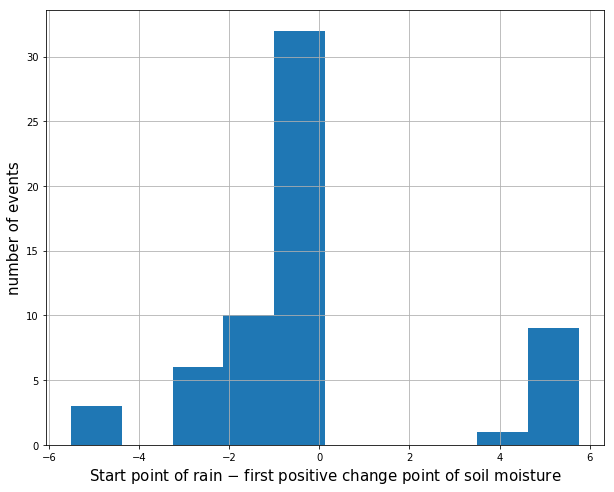

In [23]:
f=pylab.figure(figsize=(10,8))
pylab.hist(diff_ten[~np.isnan(diff_ten)])
pylab.grid()
pylab.xlabel("Start point of rain $-$ first positive change point of soil moisture",size=15)
pylab.ylabel("number of events",size=15)
pylab.show()

f.savefig("histogram_responding_time.pdf")

### Conclusion of Part 4:

** After the time analysis, we regard the timestamp of both of the systems (soil moisture sensors and rain gage) matches for most of the time. The next question becomes how to translate the soil moisture profile into infiltration quantity.**

** Bioswale can be regarded as leaking cuboid bucket filled with soil, with the length of 24ft, width of 5 ft and depth of 2 ft.**

** Soil profile I plotted above basically provides information about how soil moisture change at different depth at certain time point. If regarding soil moisture is a function of depth at any time point, doing integral of the soil moisture profile curve along depth at this time point will provides the information of the water content(infiltration quantity) of bioswale at this time point. This leads to the next topic: doing integral of the soil moisture profile curves.**

# 5. intergral of soil moisture (to get water content/infiltration quantity) every two hours in each rainfall event

** Since soil moisture data is measured only at 10, 30 and 50 centimeters below the ground, and the depth of bioswale is 2 ft (about 60 cm), interpolation of the soil moisture curve need to be done before the integral.**

**To begin with, $C^0$ Piece-wise linear interpolation is applied.**

### 5.1 Interpolation by using $C^0$ Piece-wise linear

In [24]:
def pw_linear(data):
    """
    *Input*: 
    data: numpy.array, three measurements of soil moisture at certain time point. 
    
    Output:
    P_linear: numpy.array, The interpolation data with depth ranges from -60cm (bottom of the bioswale) to 0 (top of the bioswale)
    """
    #data should be from re-arrange to be x from small to large
    x = np.linspace(-60, 0, 100)
    N = data.shape[0] - 1
    P_linear = np.zeros(x.shape)
    
    for n in range(1, N + 1):
        P_linear += ((data[n, 1] - data[n - 1, 1]) / (data[n, 0] - data[n - 1, 0]) * (x - data[n - 1, 0]) 
                             + data[n - 1, 1]) * (x > data[n - 1, 0]) * (x <= data[n, 0])
    
    #Add end points for continuity
    P_linear += np.ones(x.shape) * data[-1, 1] * (x >= data[-1, 0])
    P_linear += np.ones(x.shape) * data[0, 1] * (x < data[0, 0])
    return P_linear

### 5.2 Visualize the Interpolation 

** The following plots looks like the soil profile plots in Part 3, however, the only different is that these new plots shows the soil moisture value after the interpolation function written by myself, the interpolation can help to explicitly calculate soil moisture at any depth. This is import because when doing integral in the next step, an explicit interpolation function is required.**

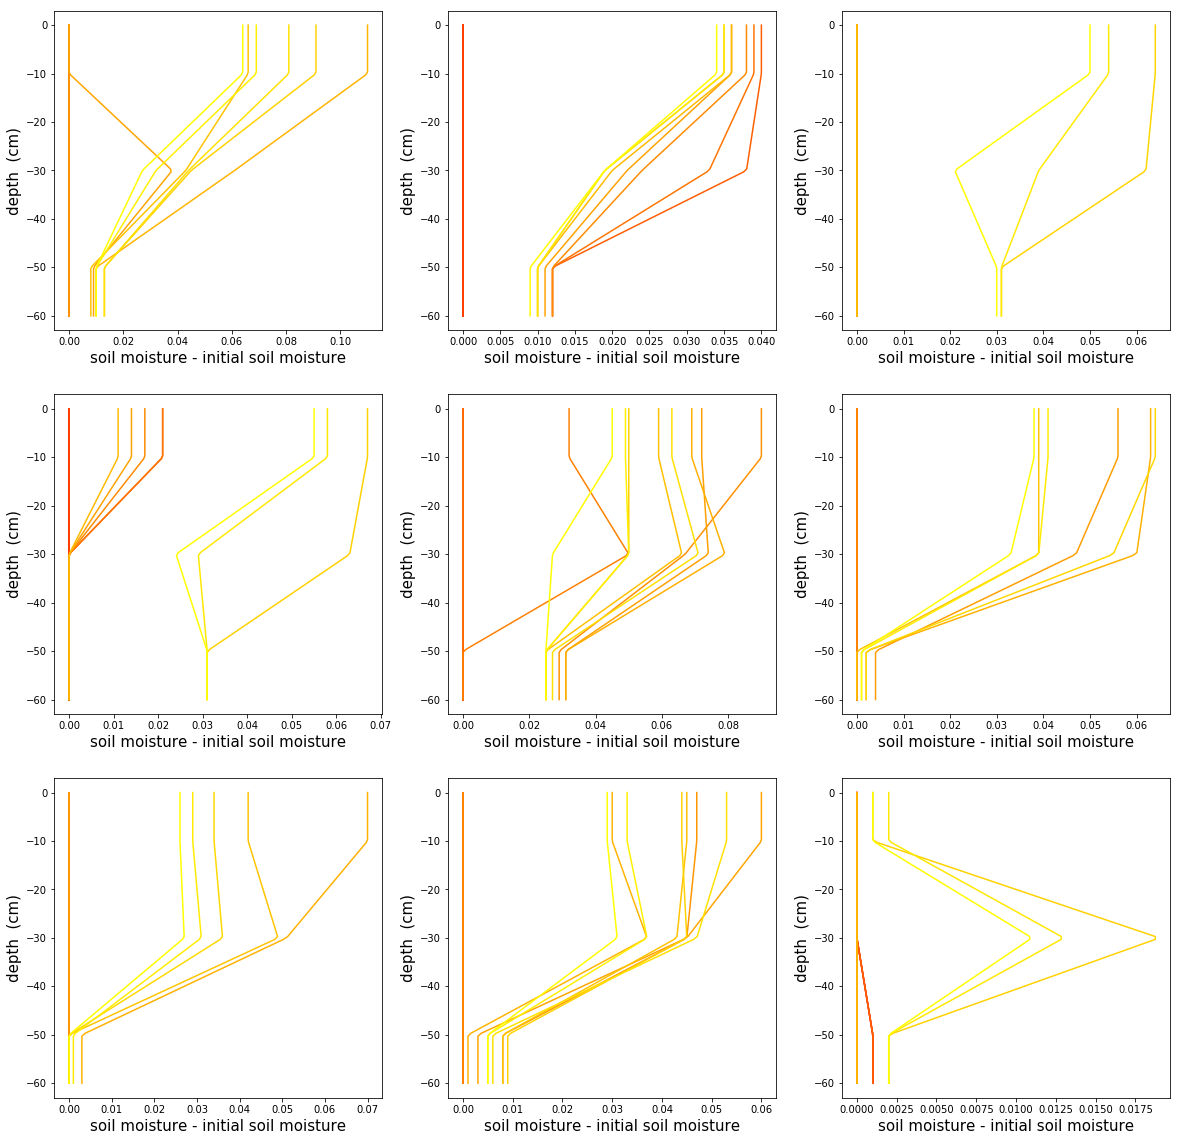

In [25]:
## delta soilmoisture data (soil moisture profile every two hours)
from matplotlib import cm
depth=np.linspace(-60, 0, 100)

fig,axes = plt.subplots(3,3,figsize=(20,20))

# 24 hours as separator, index was from the separate_rain() function above
start_index_mask=globals()['rainindex_{0}hr'.format(24)].astype(int)[:,0]
end_index_mask=globals()['rainindex_{0}hr'.format(24)].astype(int)[:,1]

colormap = plt.cm.autumn #nipy_spectral, Set1,Paired   

i=0

#plot the soil moisture profile every two hours during an rainfall event 
#with data interpolating by Piece-wise linear line
for ax in axes.flatten():  
    time_len=end_index_mask[i]-start_index_mask[i]
    len_2hr=int(np.floor(time_len/8.0)) #divide time-length of a rainfall event by 2 hours, 8 rows = 2 hours
        
    colors = [colormap(k) for k in np.linspace(0, 1,len_2hr+12)]
    
    for j in range(len_2hr+12):
        # plot the data 8 hours before the rainfall and substract the initial soil moisture data
        delta_sm=(soilfile_mask[['ten_cm','thirty_cm','fifty_cm']].iloc[(start_index_mask[i]+(j-8)*8)]-\
                 soilfile_mask[['ten_cm','thirty_cm','fifty_cm']].iloc[(start_index_mask[i]-64)])
        dsm=delta_sm*(delta_sm >= 0)
        
        #new interpolation method
        data=np.array([[-50.0,dsm.fifty_cm],[-30.0,dsm.thirty_cm],[-10.0,dsm.ten_cm]])
        intepolation_sm=pw_linear(data)
        
        #each plot represent one rainfall event
        ax.plot(intepolation_sm,depth,color=colors[j])
        ax.set_xlabel("soil moisture - initial soil moisture",size=15)
        ax.set_ylabel("depth  (cm)",size=15)
        
    i+=1

figname='soil_moisture_profile_interpolation{0}hrs.pdf'.format(24)
fig.savefig(figname)

### 5.3 Calculate water content (integral) every two hours, i.e. do quadrature along depth for each of the line in last plots

In [26]:
def f_pw_linear(data,x):
    #data should be from re-arrange to be x from small to large
    
    """
    *Input*: 
    data: numpy.array, three measurements of soil moisture at certain time point. 
    
    Output:
    y: float, The interpolation data with depth provided
    """
    
    y=0
    
    if x<= -30:
        y = ((data[1, 1] - data[0, 1]) / (data[1, 0] - data[0, 0]) * (x - data[0, 0]) 
            + data[0, 1]) * (x > data[0, 0]) * (x <= data[1, 0]) + data[0, 1] * (x < data[0, 0])
    if x > -30:
        y = ((data[2, 1] - data[1, 1]) / (data[2, 0] - data[1, 0]) * (x - data[1, 0]) 
            + data[1, 1]) * (x > data[1, 0]) * (x <= data[2, 0]) + data[2, 1] * (x > data[2, 0])

    return y

In [27]:
def quardrature(data):
    """Compute the 2-Point Gauss-Legendre Quadrature
    
    *Input*: 
    data: numpy.array, three measurements of soil moisture at certain time point. 
    
    Output:
    I_hat: float, quadrature value for a interpolated soil moisture curve
    
    """
    xi_map = lambda a,b,xi : (b - a) / 2.0 * xi + (a + b) / 2.0
    xi = [-np.sqrt(1.0 / 3.0), np.sqrt(1.0 / 3.0)]
    w = [1.0, 1.0]
    I_hat = 0.0
    N=100
    x_hat=np.linspace(-60.0,0.0,N)
    delta_x=x_hat[1]-x_hat[0]
    
    for i in range(0, N - 1):
        for k in range(len(xi)):
            I_hat += f_pw_linear(data,xi_map(x_hat[i], x_hat[i+1], xi[k])) * w[k]
    I_hat *= delta_x / 2.0
    
    return I_hat

### 5.4 visualize infiltration quantity changing with time

**There are several relationship we should know**
#### Soil moisture $= f(h)$    : soil moisture is a function of depth h
#### $A$ = area of bioswale $=100 ft^2= 92903cm^2$ : area=length* width
#### Water Content$_t$=$\int_{h} Af(h)dh$ : infiltration quantity equal to integral of soil moisture along depth
#### Water Content=$\int^0_{-60} Af(h)dh$

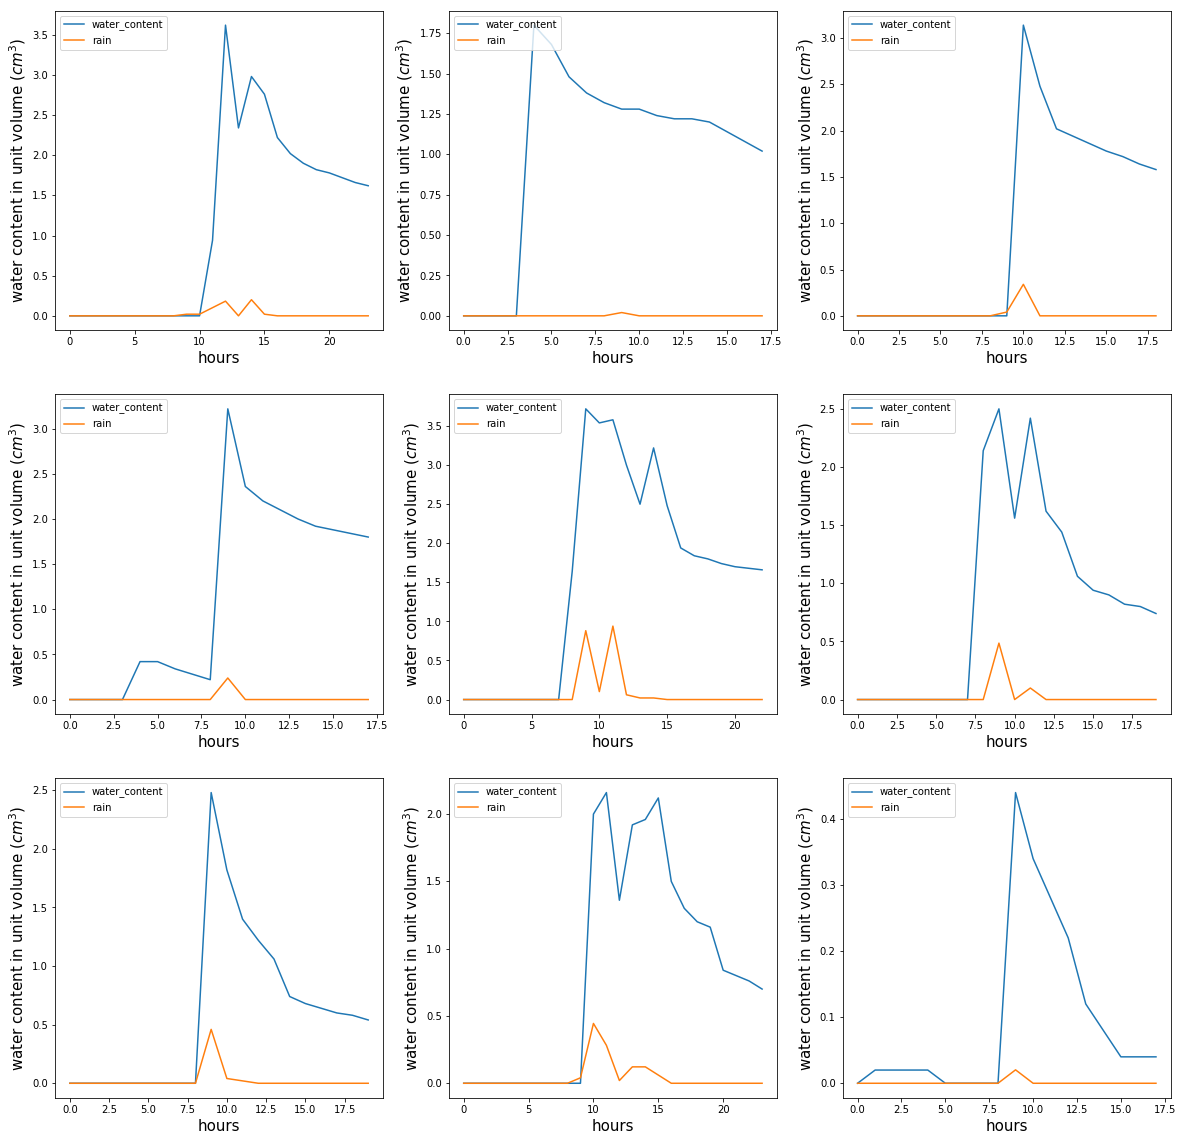

In [28]:
## delta soilmoisture data (soil moisture profile every two hours)
from matplotlib import cm
depth=np.linspace(-60, 0, 10)
# depth=[-10,-30,-50]

fig,axes = plt.subplots(3,3,figsize=(20,20))

# 24 hours as separation
start_index_mask=globals()['rainindex_{0}hr'.format(24)].astype(int)[:,0]
end_index_mask=globals()['rainindex_{0}hr'.format(24)].astype(int)[:,1]


i=0
for ax in axes.flatten(): 
    time_len=end_index_mask[i]-start_index_mask[i]
    len_2hr=int(np.floor(time_len/8.0))
        
    integral_sm=[]
    drain_2hr=[]
    time_integral=[]
    for j in range(len_2hr+18):
        delta_sm=(soilfile_mask[['ten_cm','thirty_cm','fifty_cm']].iloc[(start_index_mask[i]+(j-8)*8)]-\
                 soilfile_mask[['ten_cm','thirty_cm','fifty_cm']].iloc[(start_index_mask[i]-64)])
        dsm=delta_sm*(delta_sm >= 0)
        
        #intergral
        data=np.array([[-50.0,dsm.fifty_cm],[-30.0,dsm.thirty_cm],[-10.0,dsm.ten_cm]])
        integral_sm.append(quardrature(data)) #*92903*0.061)
        time_integral.append(soilfile_mask.index[(start_index_mask[i]+(j-8)*8)])
        drain_2hr.append(soilfile_mask.rain_cm.iloc[start_index_mask[i]+(j-9)*8:(start_index_mask[i]+8*(j-8))].sum())
        
        
    ax.plot(range(len(integral_sm)),integral_sm,label='water_content')
    ax.plot(range(len(integral_sm)),drain_2hr,label='rain')
    ax.legend(loc=2)
    ax.set_xlabel("hours",size=15)
    ax.set_ylabel("water content in unit volume ($cm^3$)",size=15)
    i+=1

figname='infiltration_quantity_rain{0}hrs.pdf'.format(24)
fig.savefig(figname)

### 5.5 Save calculated infiltration quantity with the corresponding rain data

In [29]:
## delta soilmoisture data (soil moisture profile every two hours)

# 24 hours as separation

start_index_mask=globals()['rainindex_{0}hr'.format(24)].astype(int)[:,0]
end_index_mask=globals()['rainindex_{0}hr'.format(24)].astype(int)[:,1]
  
integral_sm=[]
time_integral=[]
drain_2hr=[]

for i in range(start_index_mask.shape[0]):  
    time_len=end_index_mask[i]-start_index_mask[i]
    len_2hr=int(np.floor(time_len/8.0))

    
    for j in range(len_2hr+18):
        delta_sm=(soilfile_mask[['ten_cm','thirty_cm','fifty_cm']].iloc[(start_index_mask[i]+(j-8)*8)]-\
                 soilfile_mask[['ten_cm','thirty_cm','fifty_cm']].iloc[(start_index_mask[i]-64)])
        dsm=delta_sm*(delta_sm >= 0)
        
        #intergral
        data=np.array([[-50.0,dsm.fifty_cm],[-30.0,dsm.thirty_cm],[-10.0,dsm.ten_cm]])
        integral_sm.append(quardrature(data)*92903)
        time_integral.append(soilfile_mask.index[(start_index_mask[i]+(j-8)*8)])
        drain_2hr.append(soilfile_mask.rain_cm.iloc[start_index_mask[i]+(j-9)*8:(start_index_mask[i]+8*(j-8))].sum())

In [30]:
integral_sm=np.array(integral_sm)
time_integral=np.array(time_integral)
drain_2hr=np.array(drain_2hr)

wc_2hr={'time':time_integral,
        'water_content':integral_sm,
       'rain_accum':drain_2hr}

wc_2hr=pd.DataFrame(wc_2hr)
wc_2hr=wc_2hr.set_index('time')

In [31]:
wc_2hr.head(20)

,rain_accum,water_content
time,,
2016-08-31 10:15:00,0.00000,0.00
2016-08-31 12:15:00,0.00000,0.00
2016-08-31 14:15:00,0.00000,0.00
2016-08-31 16:15:00,0.00000,0.00
2016-08-31 18:15:00,0.00000,0.00
2016-08-31 20:15:00,0.00000,0.00
2016-08-31 22:15:00,0.00000,0.00
2016-09-01 00:15:00,0.00000,0.00
2016-09-01 02:15:00,0.00000,0.00
